<a href="https://colab.research.google.com/github/muksiddheswar/Image-Classification/blob/main/CNN_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# this saves the model to your own Google Drive
# once you run, you will have to follow a generated link and get the authorization code
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# paths for data storage
path_data = 'gdrive/MyDrive/Data/'
!ls gdrive/MyDrive/Data/identify-the-apparels-computer-vision.zip


identify-the-apparels-computer-vision.zip


In [ ]:
# file = path_data + 'identify-the-apparels-computer-vision.zip'
!unzip gdrive/MyDrive/Data/identify-the-apparels-computer-vision.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_LbELtWX/train/595.png  
  inflating: train_LbELtWX/train/5950.png  
  inflating: train_LbELtWX/train/59500.png  
  inflating: train_LbELtWX/train/59501.png  
  inflating: train_LbELtWX/train/59502.png  
  inflating: train_LbELtWX/train/59503.png  
  inflating: train_LbELtWX/train/59504.png  
  inflating: train_LbELtWX/train/59505.png  
  inflating: train_LbELtWX/train/59506.png  
  inflating: train_LbELtWX/train/59507.png  
  inflating: train_LbELtWX/train/59508.png  
  inflating: train_LbELtWX/train/59509.png  
  inflating: train_LbELtWX/train/5951.png  
  inflating: train_LbELtWX/train/59510.png  
  inflating: train_LbELtWX/train/59511.png  
  inflating: train_LbELtWX/train/59512.png  
  inflating: train_LbELtWX/train/59513.png  
  inflating: train_LbELtWX/train/59514.png  
  inflating: train_LbELtWX/train/59515.png  
  inflating: train_LbELtWX/train/59516.png  
  inflating: train_LbELtWX/train/59517.png  
  inflat

In [ ]:
# !unzip test_ScVgIM0.zip

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
# loading dataset
test = pd.read_csv('/content/test_ScVgIM0/test.csv')
train = pd.read_csv('/content/train_LbELtWX/train.csv')

# sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

train.head()

,id,label
0,1,9
1,2,0
2,3,0
3,4,3
4,5,0


In [ ]:
# loading training images
train_img = []
for img_name in tqdm(train['id']):
# for img_name in tqdm(test['id']):
    # defining the image path
    image_path = 'train_LbELtWX/train/' + str(img_name) + '.png'

    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
# defining the target
train_y = train['label'].values
train_x.shape

100%|██████████| 60000/60000 [01:14<00:00, 804.04it/s]


(60000, 28, 28)

(<Axes: >, <matplotlib.image.AxesImage at 0x7aa5569d3340>)

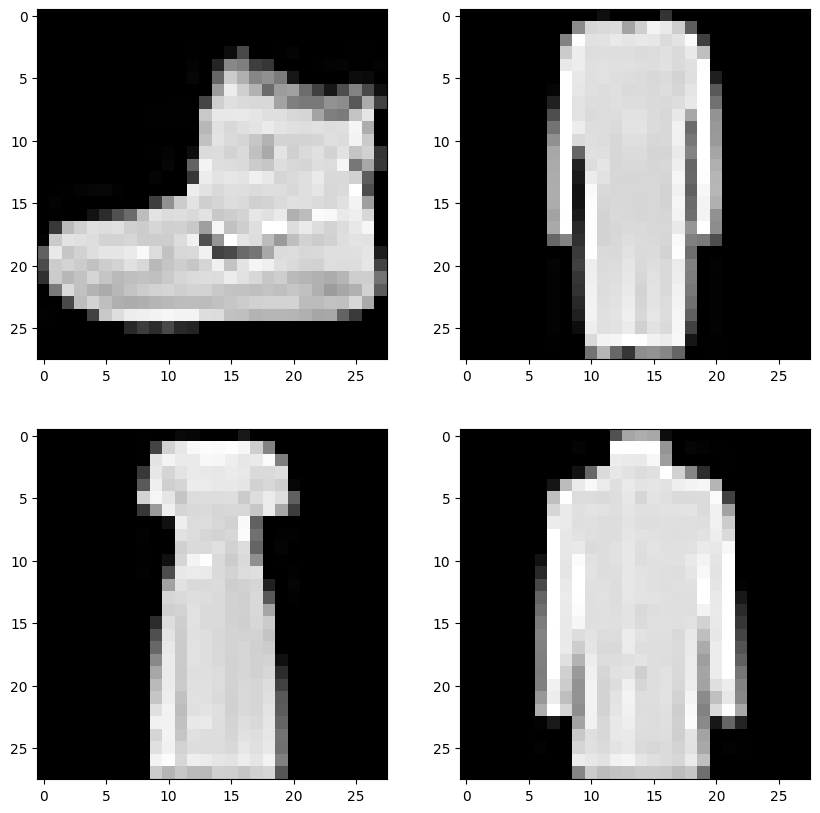

In [ ]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i], cmap='gray')
plt.subplot(222), plt.imshow(train_x[i+25], cmap='gray')
plt.subplot(223), plt.imshow(train_x[i+50], cmap='gray')
plt.subplot(224), plt.imshow(train_x[i+75], cmap='gray')

In [ ]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((54000, 28, 28), (54000,)), ((6000, 28, 28), (6000,)))

In [ ]:
# converting training images into torch format
train_x = train_x.reshape(54000, 1, 28, 28)
# train_x = train_x.reshape(9000, 1, 28, 28)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([54000, 1, 28, 28]), torch.Size([54000]))

In [ ]:
# converting validation images into torch format
val_x = val_x.reshape(6000, 1, 28, 28)
# val_x = val_x.reshape(1000, 1, 28, 28)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([6000, 1, 28, 28]), torch.Size([6000]))

In [ ]:
class Net(Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()

    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)



    y_train = y_train.type(torch.cuda.LongTensor)
    y_val = y_val.type(torch.cuda.LongTensor)

    # print("Here")
    # print(output_train.shape, y_train.shape)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val,loss_train)

In [ ]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.5108, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.5148, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(3.5414, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(3.5201, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(1.9102, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.8719, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(1.5271, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.4821, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(1.5717, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.5381, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(1.4808, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.4524, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  13 	 loss : tensor(1.3338, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(1.3067, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  15 	 loss

In [ ]:
train_losses = [t.detach().cpu().numpy() for t in train_losses] # Detach and then move to cpu, convert to numpy array
val_losses = [v.detach().cpu().numpy() for v in val_losses]   # Detach and then move to cpu, convert to numpy array

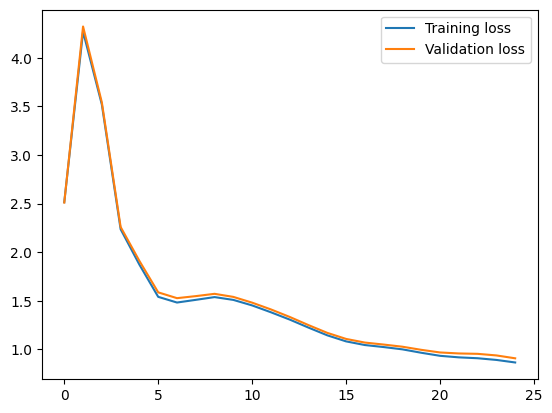

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()